In [1]:
import pandas as pd
import numpy as np

from common.serialization import pickle_save, pickle_load

from feature_pr import * #make_counters, make_counters_test, compress_vals, replace_val, make_pairs

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

In [4]:
data = pd.read_csv('data/credit_train.csv', sep=';', encoding='cp1251')
data_test = pd.read_csv('data/credit_test.csv', sep=';', encoding='cp1251')

In [5]:
a = ['РЕСП', 'ОБЛ', 'ОБЛАСТЬ', 'КРАЙ', 'ОБЛ.', 'РЕСП.', 'Р-Н', 'АО', 'КРАЙ.', '-', 'Г', 'Г.', 'АОБЛ', 'РЕСПУБЛИКА',
    'ОКРУГ', 'АВТОНОМНЫЙ']

data.monthly_income.fillna(-1, inplace=True)
data.living_region.fillna('N', inplace=True)
data.credit_count.fillna(-1, inplace=True)
data.overdue_credit_count.fillna(-1, inplace=True)
data['credit_sum'] = data.credit_sum.apply(lambda x: float(x.replace(',', '.')))
data['score_shk'] = data.score_shk.apply(lambda x: float(x.replace(',', '.')))
data['living_region'] = data.living_region.apply(lambda x: ''.join([y for y in x.lower().split() if y not in a]))

data_test.monthly_income.fillna(-1, inplace=True)
data_test.living_region.fillna('N', inplace=True)
data_test.credit_count.fillna(-1, inplace=True)
data_test.overdue_credit_count.fillna(-1, inplace=True)
data_test['credit_sum'] = data_test.credit_sum.apply(lambda x: float(x.replace(',', '.')))
data_test['score_shk'] = data_test.score_shk.apply(lambda x: float(x.replace(',', '.')))
data_test['living_region'] = data_test.living_region.apply(lambda x: ''.join([y for y in x.lower().split() if y not in a]))


c = data_test.living_region.unique()
d = data.living_region.unique()
for elem in c:
    if elem not in d:
        data_test.loc[data_test.living_region == elem, 'living_region'] = 'N'

In [6]:
counters_cols = ['gender', 'marital_status', 'job_position', 'credit_month', 'tariff_id', 
                'education', 'living_region', 'age', 'credit_count', 'overdue_credit_count',
                'credit_sum_group', 'monthly_income_group', 'score_shk_group']
other_cols = ['credit_sum', 'score_shk', 'monthly_income']

# Объединим редко встречающиеся значения признаков
data.loc[data.credit_count > 7, 'credit_count'] = 7
data_test.loc[data_test.credit_count > 7, 'credit_count'] = 7
data.loc[data.overdue_credit_count > 2, 'credit_count'] = 2
data_test.loc[data_test.credit_count > 2, 'credit_count'] = 2

compress_vals(data, data_test, 'living_region', 30, 'N')
compress_vals(data, data_test, 'tariff_id', 30, 2.0)
compress_vals(data, data_test, 'job_position', 30, 'N')

data['age_group'] = 0
data_test['age_group'] = 0
a = [range(18, 22), range(22, 25), range(25, 38), range(38, 50), range(50, 58), range(58, 66), range(66, 100)]
for i in range(len(a)):
    for val in a[i]:
        data.loc[data.age == val, 'age_group'] = i
        data_test.loc[data_test.age == val, 'age_group'] = i

a = []
for i in range(4):
    a.append([])
    a[i].append(i * 20000)
    a[i].append((i + 1) * 20000)
a.append([])
a[4].append(80000)
a[4].append(10000000)
data['credit_sum_group'] = 0
data_test['credit_sum_group'] = 0
for i in range(len(a)):
    data.loc[(data.credit_sum > a[i][0]) & (data.credit_sum <= a[i][1]), 'credit_sum_group'] = i
    data_test.loc[(data_test.credit_sum > a[i][0]) & (data_test.credit_sum <= a[i][1]), 'credit_sum_group'] = i 
    
a = []
for i in range(4):
    a.append([])
    a[i].append(i * 20000)
    a[i].append((i + 1) * 20000)
a.append([])
a[4].append(100000)
a[4].append(10000000)
data['monthly_income_group'] = 0
data_test['monthly_income_group'] = 0
for i in range(len(a)):
    data.loc[(data.monthly_income > a[i][0]) & (data.monthly_income <= a[i][1]), 'monthly_income_group'] = i
    data_test.loc[(data_test.monthly_income > a[i][0]) & (data_test.monthly_income <= a[i][1]), 'monthly_income_group'] = i

a = []
for i in range(4):
    a.append([])
    a[i].append(i * 0.2)
    a[i].append((i + 1) * 0.2)
a.append([])
a[4].append(0.8)
a[4].append(100.0)
data['score_shk_group'] = 0
data_test['score_shk_group'] = 0
for i in range(len(a)):
    data.loc[(data.score_shk > a[i][0]) & (data.score_shk <= a[i][1]), 'score_shk_group'] = i
    data_test.loc[(data_test.score_shk > a[i][0]) & (data_test.score_shk <= a[i][1]), 'score_shk_group'] = i    

replace_val(data, 'credit_month', [30, 31, 32], 36)
replace_val(data_test, 'credit_month', [30, 31, 32], 36)
replace_val(data, 'credit_month', [21, 22, 23, 25, 26, 27, 28, 29], 24)
replace_val(data_test, 'credit_month', [21, 22, 23, 25, 26, 27, 28, 29], 24)
replace_val(data, 'credit_month', [17], 18)
replace_val(data_test, 'credit_month', [17], 18)

#пары признаков
pairs_to_col = ['gender', 'marital_status', 'credit_count', 'overdue_credit_count', 'age_group', 'job_position',
    'education', 'credit_sum_group', 'monthly_income_group', 'score_shk_group']

data, pair_cols = make_pairs(data, pairs_to_col)
data_test, pair_cols = make_pairs(data_test, pairs_to_col)

for col in pair_cols:
    c = data_test[col].unique()
    d = data[col].unique()
    for elem in c:
        if elem not in d:
            data_test.loc[data_test[col] == elem, col] = 'N'
    compress_vals(data, data_test, col, 30, 'N')

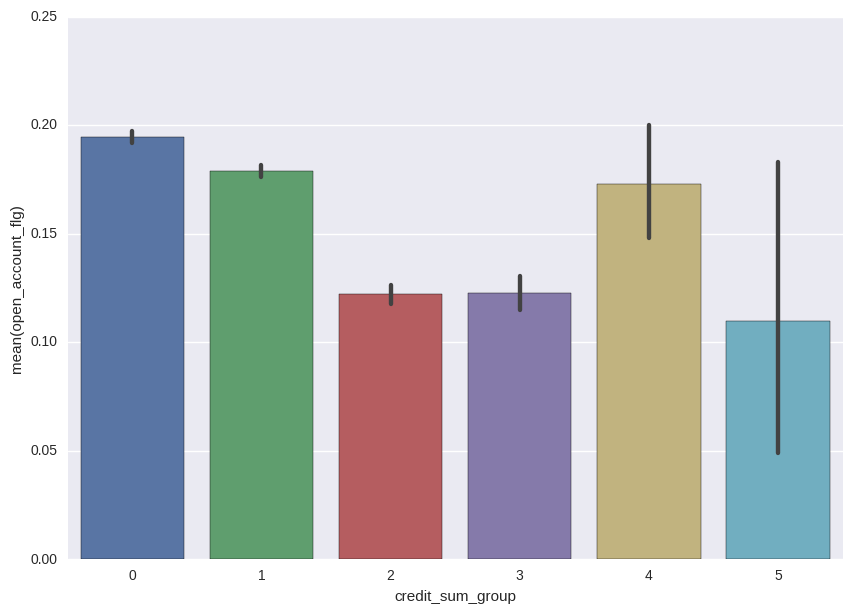

In [7]:
sns.barplot(x=data.credit_sum_group, y=data.open_account_flg)

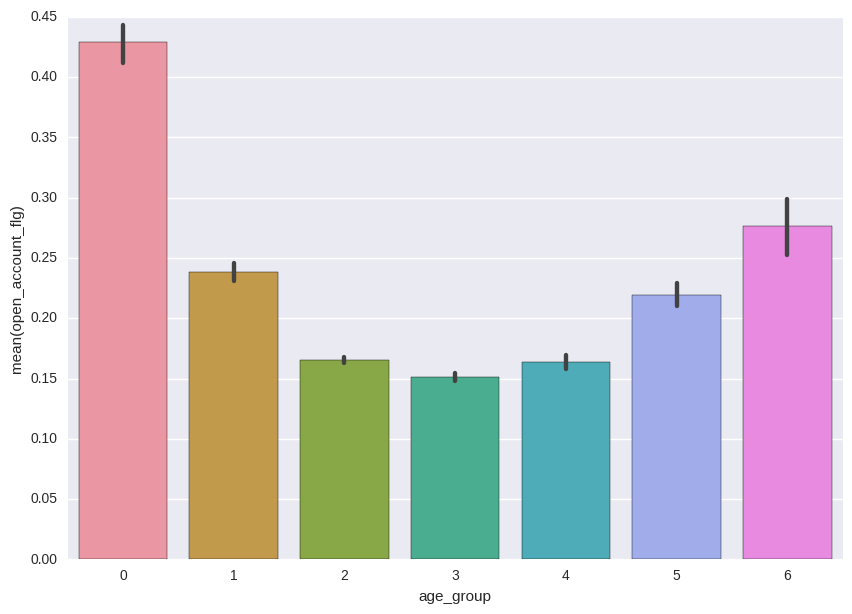

In [8]:
sns.barplot(x=data.age_group, y=data.open_account_flg)

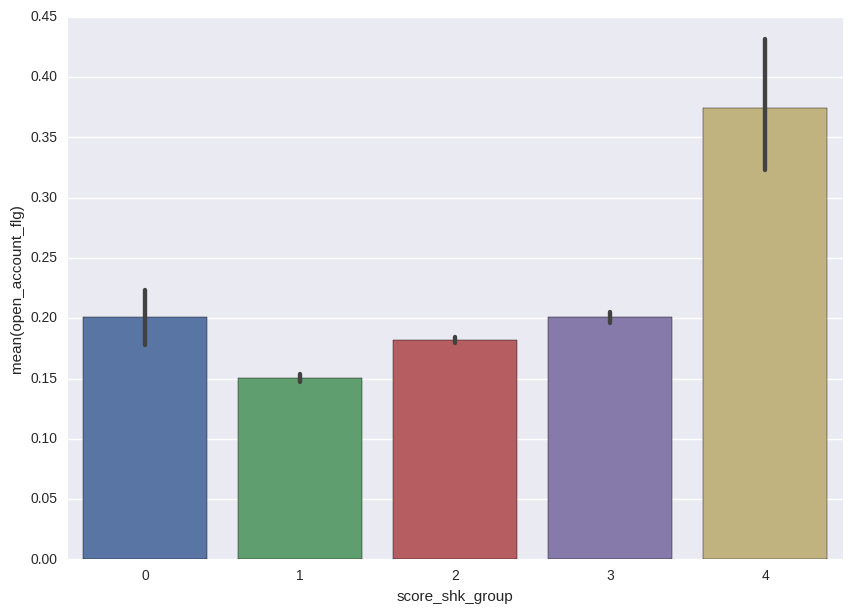

In [7]:
sns.barplot(x=data.score_shk_group, y=data.open_account_flg)

In [8]:
#счетчики
X_train = np.hstack((make_counters(X=data[counters_cols + pair_cols].values, y=data.open_account_flg.values, 
                                   n_folds=25), data[other_cols]))
X_test = np.hstack((make_counters_test(data_test[counters_cols + pair_cols].values, data[counters_cols + pair_cols].values, 
                                       data.open_account_flg.values), data_test[other_cols]))

In [9]:
pickle_save(X_train, 'data/task1_data/X_train.pkl')
pickle_save(X_test, 'data/task1_data/X_test.pkl')
pickle_save(data_test.client_id.values, 'data/task1_data/_ID_.pkl')
pickle_save(data.open_account_flg.values, 'data/task1_data/y_train.pkl')

In [10]:
X_test.shape, X_train.shape

((91940, 61), (170746, 61))